# 90-Day Revenue Forecasting with ARIMA Time Series Modeling  
**Author: May Cooper**

## Overview

This project applies ARIMA time series modeling to forecast daily revenue over a 90-day horizon using two years of historical business data. The analysis includes stationarity testing, model selection through AIC-based grid search, and residual diagnostics to ensure model validity. Forecast results are visualized and evaluated using RMSE to assess accuracy and reliability.

**Research question:**  
How accurately can daily revenue be forecasted for the next 90 days using historical time series data and ARIMA modeling?

## Goal

Prepare the dataset for time series forecasting by:
1. Parsing and indexing the dataset by date.
2. Evaluating and transforming for stationarity (ADF test and differencing).
3. Identifying ARIMA parameters using ACF/PACF plots and grid search.
4. Fitting the ARIMA model and evaluating forecast accuracy with RMSE.

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For stationarity tests and ARIMA modeling
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For train/test splitting and error metrics
from sklearn.metrics import mean_squared_error

# For spectral density or seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings

# Suppress warnings related to statsmodels index issues
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# Suppress future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
file_path = r"churn_clean.csv"

df = pd.read_csv(file_path)

# Set "Day" as the index
df.set_index('Day', inplace=True)

# Inspect the first few rows
print(df.head())

# Check for missing values and data types
print(df.isnull().sum())
print(df.dtypes)


      Revenue
Day          
1    0.000000
2    0.000793
3    0.825542
4    0.320332
5    1.082554
Revenue    0
dtype: int64
Revenue    float64
dtype: object


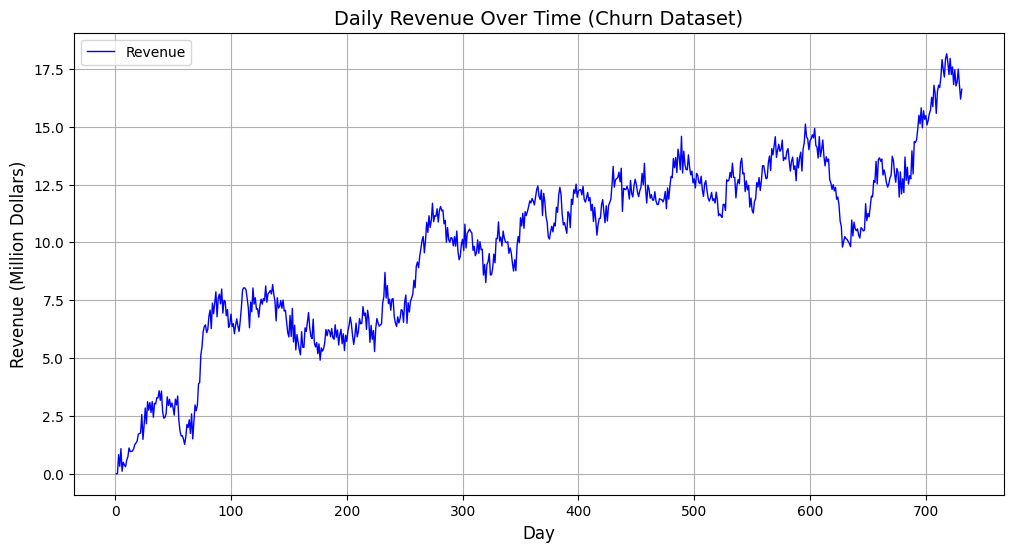

In [ ]:
# Data Visualization

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Revenue'], label='Revenue', color='blue', linewidth=1)
plt.title('Daily Revenue Over Time (Churn Dataset)', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Revenue (Million Dollars)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Check the frequency of the time series
print("First Day in the Dataset:", df.index.min())
print("Last Day in the Dataset:", df.index.max())

# Check for missing days (gaps)
expected_days = set(range(df.index.min(), df.index.max() + 1))
actual_days = set(df.index)
missing_days = expected_days - actual_days

if missing_days:
    print("Missing Days:", missing_days)
else:
    print("No gaps in the sequence; all days are accounted for.")

# Length of the sequence
sequence_length = len(df)
print("Length of the sequence (total number of days):", sequence_length)

# Determine if the dataset is consecutive
if len(missing_days) == 0 and sequence_length == (df.index.max() - df.index.min() + 1):
    print("The dataset represents a consecutive daily time series.")
else:
    print("The dataset is not fully consecutive.")

First Day in the Dataset: 1
Last Day in the Dataset: 731
No gaps in the sequence; all days are accounted for.
Length of the sequence (total number of days): 731
The dataset represents a consecutive daily time series.


In [ ]:
# Evaluate the Stationarity of the Time Series
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df['Revenue'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value}")

# Interpretation
if adf_result[1] < 0.05:
    print("The time series is stationary (reject the null hypothesis).")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -1.9246121573101809
p-value: 0.32057281507939783
Critical Values:
    1%: -3.4393520240470554
    5%: -2.8655128165959236
    10%: -2.5688855736949163
The time series is non-stationary (fail to reject the null hypothesis).


In [6]:
# Apply first-order differencing
df['Revenue_diff'] = df['Revenue'].diff()

# Drop null values caused by differencing
df_diff = df['Revenue_diff'].dropna()

# Perform ADF test again on the differenced series
from statsmodels.tsa.stattools import adfuller

adf_result_diff = adfuller(df_diff)

print("ADF Statistic (Differenced):", adf_result_diff[0])
print("p-value (Differenced):", adf_result_diff[1])
print("Critical Values (Differenced):")
for key, value in adf_result_diff[4].items():
    print(f"    {key}: {value}")

# Interpretation
if adf_result_diff[1] < 0.05:
    print("The differenced time series is stationary (reject the null hypothesis).")
else:
    print("The differenced time series is still non-stationary (fail to reject the null hypothesis).")

ADF Statistic (Differenced): -44.874527193875984
p-value (Differenced): 0.0
Critical Values (Differenced):
    1%: -3.4393520240470554
    5%: -2.8655128165959236
    10%: -2.5688855736949163
The differenced time series is stationary (reject the null hypothesis).


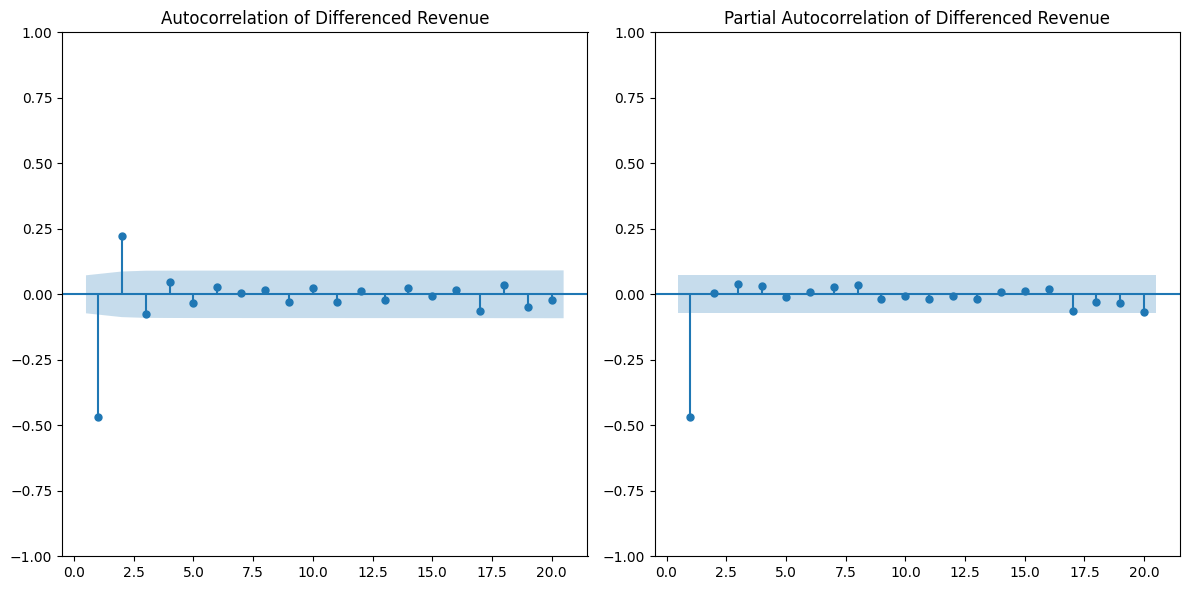

In [7]:
# Visualization of Autocorrelation and Partial Autocorrelation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(df_diff, lags=20, zero=False, ax=plt.gca())
plt.title('Autocorrelation of Differenced Revenue')

plt.subplot(1, 2, 2)
plot_pacf(df_diff, lags=20, zero=False, ax=plt.gca())
plt.title('Partial Autocorrelation of Differenced Revenue')

plt.tight_layout()
plt.show()

In [ ]:
# Train/Test Split

# We apply ARIMA on the differenced df_diff

# Let's define a train size of 80% differenced data
train_size = int(len(df_diff) * 0.8)
train, test = df_diff[:train_size], df_diff[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 584, Test size: 146


In [ ]:
# Save the cleaned dataset

cleaned_filename = 'cleaned_churn_data1.csv'
df.to_csv(cleaned_filename, index=True)

print(f"Cleaned dataset saved as '{cleaned_filename}'")

Cleaned dataset saved as 'cleaned_churn_data1.csv'


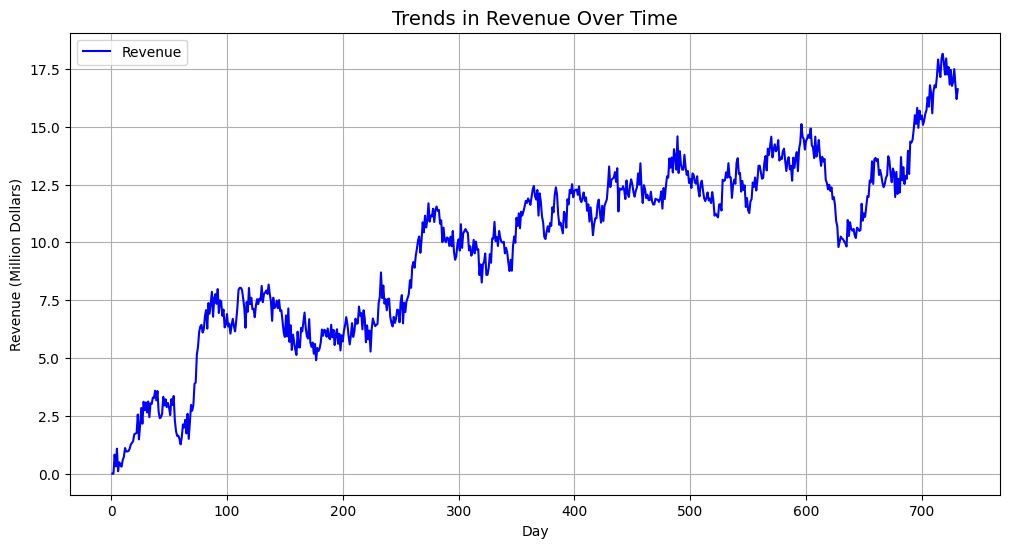

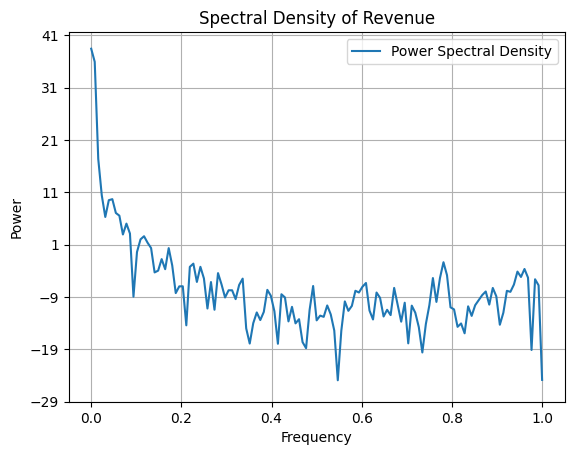

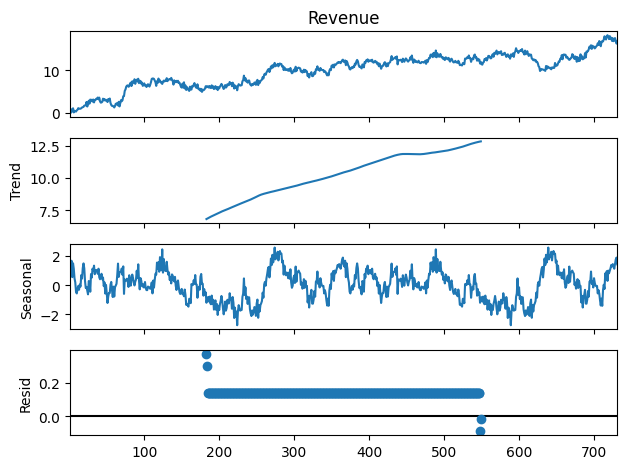

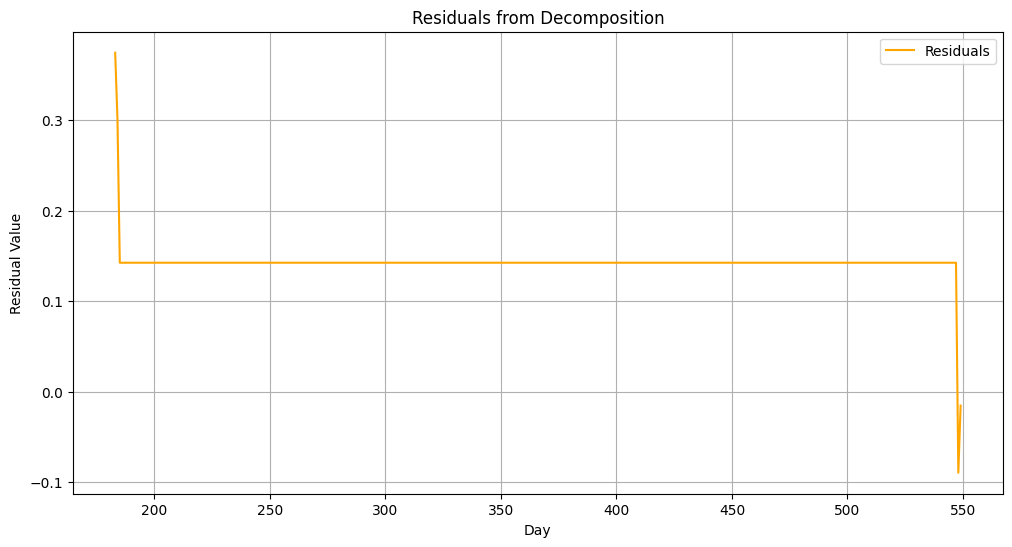

In [ ]:
# Annotated Findings: Trends, Spectral Density, Decomposition

# Plot trends and patterns
plt.figure(figsize=(12, 6))
plt.plot(df['Revenue'], label='Revenue', color='blue')
plt.title('Trends in Revenue Over Time', fontsize=14)
plt.xlabel('Day')
plt.ylabel('Revenue (Million Dollars)')
plt.legend()
plt.grid(True)
plt.show()

# Spectral Density Analysis
plt.psd(df['Revenue'], NFFT=256, label='Power Spectral Density')
plt.title('Spectral Density of Revenue')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

# Decompose the time series to observe components
decomposition = seasonal_decompose(df['Revenue'], model='additive', period=365)
decomposition.plot()
plt.show()

# Residuals of the decomposed series
residuals = decomposition.resid.dropna()

# Check residuals for trends or significant changes
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='orange')
plt.title('Residuals from Decomposition')
plt.xlabel('Day')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.show()

Checking if the data has strong seasonality

In [11]:
from statsmodels.tsa.stattools import acf
import numpy as np

seasonal_lag = 365

# Calculate autocorrelations
autocorrelations = acf(df['Revenue'], nlags=seasonal_lag, fft=True)

# Print autocorrelation values
print("Autocorrelations at seasonal lags:")
for lag, value in enumerate(autocorrelations[:seasonal_lag + 1]):
    print(f"Lag {lag}: {value:.4f}")

# Highlight potential seasonality if autocorrelation at seasonal lag is high
seasonal_autocorr = autocorrelations[seasonal_lag]
if abs(seasonal_autocorr) > 0.3:  # Threshold for identifying seasonality
    print(f"\nPotential seasonality detected! Autocorrelation at lag {seasonal_lag}: {seasonal_autocorr:.4f}")
else:
    print(f"\nNo strong seasonality detected at lag {seasonal_lag}. Autocorrelation: {seasonal_autocorr:.4f}")

Autocorrelations at seasonal lags:
Lag 0: 1.0000
Lag 1: 0.9838
Lag 2: 0.9768
Lag 3: 0.9658
Lag 4: 0.9555
Lag 5: 0.9452
Lag 6: 0.9347
Lag 7: 0.9236
Lag 8: 0.9126
Lag 9: 0.9007
Lag 10: 0.8899
Lag 11: 0.8782
Lag 12: 0.8678
Lag 13: 0.8567
Lag 14: 0.8457
Lag 15: 0.8343
Lag 16: 0.8237
Lag 17: 0.8127
Lag 18: 0.8026
Lag 19: 0.7924
Lag 20: 0.7836
Lag 21: 0.7752
Lag 22: 0.7656
Lag 23: 0.7599
Lag 24: 0.7507
Lag 25: 0.7427
Lag 26: 0.7354
Lag 27: 0.7275
Lag 28: 0.7209
Lag 29: 0.7144
Lag 30: 0.7083
Lag 31: 0.7024
Lag 32: 0.6965
Lag 33: 0.6901
Lag 34: 0.6843
Lag 35: 0.6789
Lag 36: 0.6730
Lag 37: 0.6665
Lag 38: 0.6601
Lag 39: 0.6542
Lag 40: 0.6493
Lag 41: 0.6433
Lag 42: 0.6377
Lag 43: 0.6326
Lag 44: 0.6270
Lag 45: 0.6230
Lag 46: 0.6188
Lag 47: 0.6143
Lag 48: 0.6091
Lag 49: 0.6045
Lag 50: 0.5985
Lag 51: 0.5927
Lag 52: 0.5874
Lag 53: 0.5816
Lag 54: 0.5766
Lag 55: 0.5706
Lag 56: 0.5642
Lag 57: 0.5568
Lag 58: 0.5494
Lag 59: 0.5419
Lag 60: 0.5338
Lag 61: 0.5266
Lag 62: 0.5192
Lag 63: 0.5127
Lag 64: 0.5064


In [12]:
# For weekly seasonality (lag=7)
seasonal_lag_7 = 7
acf_values_7 = acf(df['Revenue'], nlags=seasonal_lag_7)

print(f"ACF values (up to lag={seasonal_lag_7}):")
for lag, value in enumerate(acf_values_7):
    print(f"Lag {lag}: {value:.4f}")

print("\n-------------------\n")

# For monthly seasonality (lag=30)
seasonal_lag_30 = 30
acf_values_30 = acf(df['Revenue'], nlags=seasonal_lag_30)

print(f"ACF values (up to lag={seasonal_lag_30}):")
for lag, value in enumerate(acf_values_30):
    print(f"Lag {lag}: {value:.4f}")

ACF values (up to lag=7):
Lag 0: 1.0000
Lag 1: 0.9838
Lag 2: 0.9768
Lag 3: 0.9658
Lag 4: 0.9555
Lag 5: 0.9452
Lag 6: 0.9347
Lag 7: 0.9236

-------------------

ACF values (up to lag=30):
Lag 0: 1.0000
Lag 1: 0.9838
Lag 2: 0.9768
Lag 3: 0.9658
Lag 4: 0.9555
Lag 5: 0.9452
Lag 6: 0.9347
Lag 7: 0.9236
Lag 8: 0.9126
Lag 9: 0.9007
Lag 10: 0.8899
Lag 11: 0.8782
Lag 12: 0.8678
Lag 13: 0.8567
Lag 14: 0.8457
Lag 15: 0.8343
Lag 16: 0.8237
Lag 17: 0.8127
Lag 18: 0.8026
Lag 19: 0.7924
Lag 20: 0.7836
Lag 21: 0.7752
Lag 22: 0.7656
Lag 23: 0.7599
Lag 24: 0.7507
Lag 25: 0.7427
Lag 26: 0.7354
Lag 27: 0.7275
Lag 28: 0.7209
Lag 29: 0.7144
Lag 30: 0.7083


Optimal ARIMA Parameters: (1, 0, 0)
Optimal AIC: 773.8925878321596
                               SARIMAX Results                                
Dep. Variable:           Revenue_diff   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -383.946
Date:                Thu, 23 Jan 2025   AIC                            773.893
Time:                        03:38:26   BIC                            787.002
Sample:                             0   HQIC                           779.002
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.013      1.758      0.079      -0.003       0.049
ar.L1         -0.4597      0.036    -12.654      0.000      -0.5

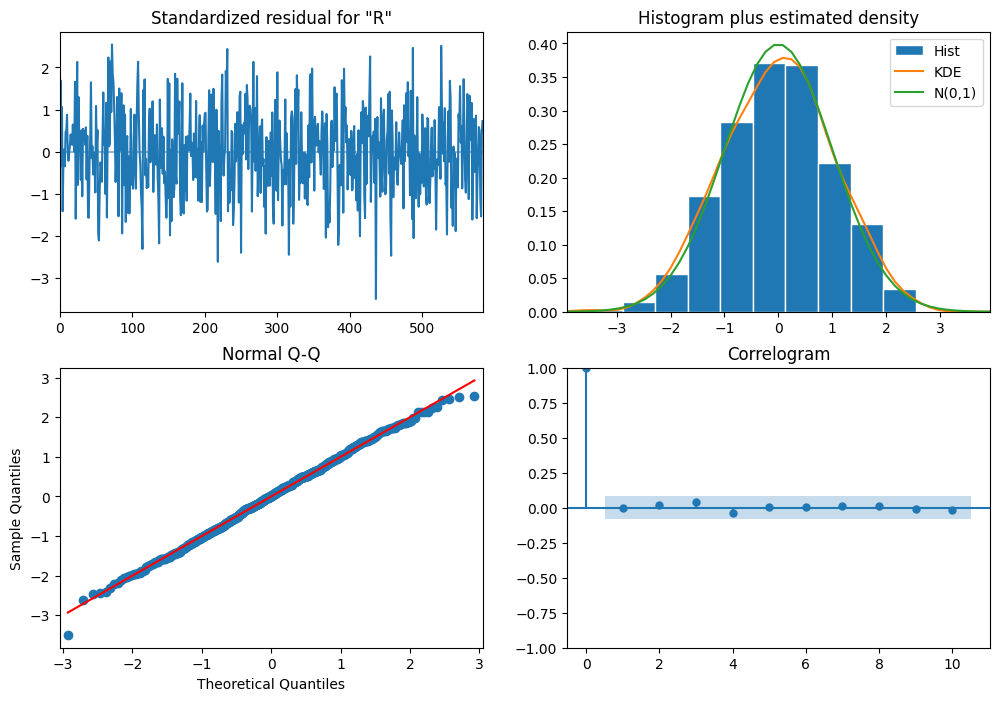

In [ ]:
# Fit ARIMA Model

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Optimize ARIMA Model with Grid Search

# Define p, d, q ranges
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Perform Grid Search to find the best ARIMA parameters
best_aic = float('inf')
best_pdq = None
best_model = None

for param in pdq:
    try:
        temp_model = ARIMA(train, order=param)
        temp_results = temp_model.fit()
        if temp_results.aic < best_aic:
            best_aic = temp_results.aic
            best_pdq = param
            best_model = temp_results
    except Exception as e:
        continue

# Print the best parameters and corresponding AIC value
print(f"Optimal ARIMA Parameters: {best_pdq}")
print(f"Optimal AIC: {best_aic}")

# Fit ARIMA Model Using Best Parameters

# Use the optimal parameters to fit the final model
model = ARIMA(train, order=best_pdq)
results = model.fit()

# Print the summary of the fitted model
print(results.summary())

# Check Residuals of the Model

# Plot residual diagnostics to ensure the model assumptions hold
results.plot_diagnostics(figsize=(12, 8))
plt.show()

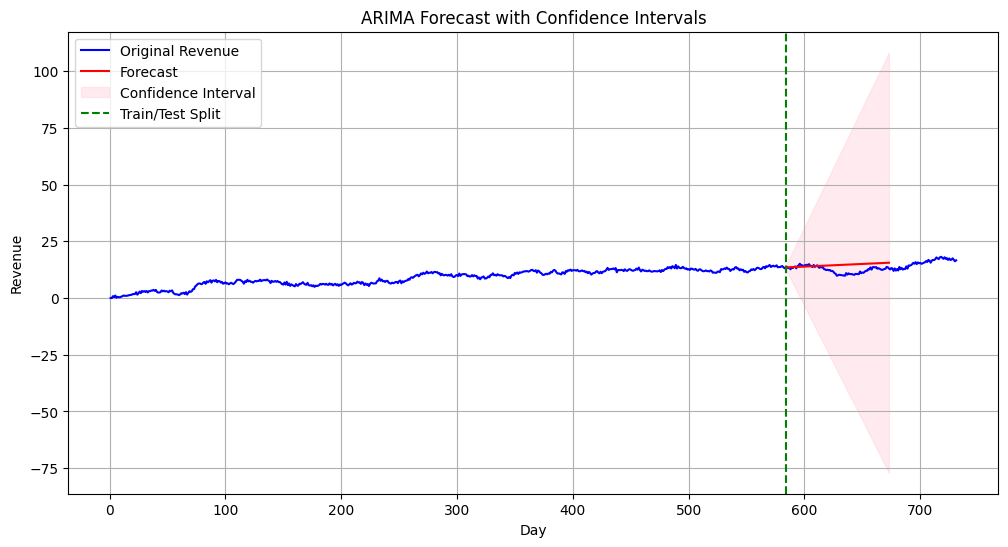

In [14]:
# Forecasting the next 90 days
forecast_steps = 90
forecast = results.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Reverting to the original scale using cumulative sum
forecast_mean_cumsum = forecast_mean.cumsum() + df['Revenue'].iloc[train_size - 1]
confidence_intervals_cumsum = confidence_intervals.cumsum()
confidence_intervals_cumsum.iloc[:, 0] += df['Revenue'].iloc[train_size - 1]
confidence_intervals_cumsum.iloc[:, 1] += df['Revenue'].iloc[train_size - 1]

# Plotting the ARIMA forecast with confidence cone
plt.figure(figsize=(12, 6))
plt.plot(df['Revenue'], label='Original Revenue', color='blue')
plt.plot(range(train_size, train_size + forecast_steps), forecast_mean_cumsum, label='Forecast', color='red')
plt.fill_between(
    range(train_size, train_size + forecast_steps),
    confidence_intervals_cumsum.iloc[:, 0],
    confidence_intervals_cumsum.iloc[:, 1],
    color='pink', alpha=0.3, label='Confidence Interval'
)
plt.axvline(x=train_size, color='green', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('ARIMA Forecast with Confidence Intervals')
plt.xlabel('Day')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [15]:
# Combine the forecasted values and confidence intervals into a DataFrame
forecast_text_df = pd.DataFrame({
    'Day': range(len(df) + 1, len(df) + 1 + forecast_steps),
    'Forecasted Revenue': forecast_mean_cumsum.values,
    'Lower CI': confidence_intervals_cumsum.iloc[:, 0].values,
    'Upper CI': confidence_intervals_cumsum.iloc[:, 1].values
})

# Display the forecast as text
print("Forecast for the Next 90 Days:")
print(forecast_text_df.to_string(index=False))

Forecast for the Next 90 Days:
 Day  Forecasted Revenue   Lower CI   Upper CI
 732           13.456264  12.541221  14.371307
 733           13.512706  11.590576  15.434835
 734           13.520853  10.573245  16.468460
 735           13.551199   9.574270  17.528129
 736           13.571342   8.564279  18.578404
 737           13.596174   7.558808  19.633540
 738           13.618851   6.551145  20.686557
 739           13.642519   5.544465  21.740572
 740           13.665731   4.537328  22.794133
 741           13.689153   3.530401  23.847904
 742           13.712478   2.523376  24.901579
 743           13.735847   1.516397  25.955298
 744           13.759197   0.509396  27.008997
 745           13.782555  -0.497595  28.062705
 746           13.805910  -1.504590  29.116409
 747           13.829266  -2.511583  30.170115
 748           13.852621  -3.518577  31.223820
 749           13.875977  -4.525571  32.277525
 750           13.899333  -5.532565  33.331230
 751           13.922688  -6.

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

# "test" is the differenced values for the test period
# "results" is your fitted ARIMA model

# Forecast as many steps as your test set length:
test_pred_diff = results.forecast(steps=len(test))

# Calculate MSE and RMSE on the differenced scale
mse_diff = mean_squared_error(test, test_pred_diff)
rmse_diff = np.sqrt(mse_diff)

print(f"Test MSE (differenced scale): {mse_diff}")
print(f"Test RMSE (differenced scale): {rmse_diff}")

Test MSE (differenced scale): 0.3246275629527159
Test RMSE (differenced scale): 0.5697609700152476
